Primero importamos las librerías necesarias para resolver el problema

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

Luego, importamos el data set en un array numpy y lo graficamos

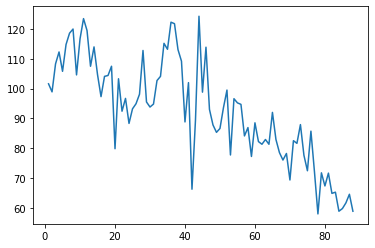

In [3]:
series = np.loadtxt("seriesautos.txt", dtype=np.float32)
time = np.arange(1, 89)
plt.plot(time, series)

Aquí dividimos a los datos en datos de entrenamiento y validación

In [4]:
split_time = 84
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

Aquí definimos la ventana que usaremos para entrenar la red, es decir, qué datos serán tenidos en cuenta a la hora de entrenar la red. Un window_size = 10, quiere decir que tomaré 10 valores y predeciré el 11avo. 

El batch size es la cantidad de veces que entrenaré la red neuronales antes de actualizar la función de coste. Y, finalmente, el shuffle_buffer hace que la selección de muestras aleatoreas sea más rápida (en vez es elegír entre todos los valores del dataset, elige entre los primeros 'shuffle_buffer').

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

window_size = 10
batch_size = 16
shuffle_buffer_size = 50
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

Aquí definimos un Callback para que el entrenamiento de la red se interrumpa si obtenemos un valor de 'loss' < 100. El valor 100 fue decidido manualmente luego de varias pruebas para obtener un balance entre cantidad de iteraciones y generalización del sistema.

In [6]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<100):
      print("\nYa se alcanzó una 'loss' igual a 100 entonces paramos!")
      self.model.stop_training = True

callbacks = myCallback()

En esta etapa diseñamos el modelo. Al principio de la red colocamos una capa convolucional unidimencional, esto no es necesario pero suele ser útil una capa así cuando trabajamos con señales en el tiempo antes de entrar las capas recurrentes. La capa tiene 60 filtros de 5x5, con un stride = 1, padding causal es para que no tenga en cuenta valores posteriores a t (señal causal) y usamos un función de activación 'relu' como en todo el resto de la red.

Luego agregamos dos capas LSTM (redes recurrente con memoria) con 60 nodos cada una, return_sequences = True indica que la salida de la capa va a ser de la misma longitud de la entrada. Luego agregamos 3 capas densas, una con 30 unidadades, una con 10 unidades y una última con una sola unidad para estimar el valor futuro. La última capa Lambda solo ayuda a que la salida sea del orden de magnitud de los valores que típicamente maneja la señal.

Cuando entrenamos usamos la función del error cuadrático medio, el optimizador Adam y asignamos 100 épocas (aunque gracias al callback definido anteriormente el entrenamiento se interrumpe en la época 55 porque ya alcanza una 'loss' menor a 100.



In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Lambda
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

model = Sequential([
  Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  LSTM(60, return_sequences=True), 
  LSTM(60, return_sequences=True),
  Dense(30, activation="relu"), 
  Dense(10, activation="relu"),
  Dense(1), 
  Lambda(lambda x: x * 100)
])

model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[callbacks])

Epoch 1/100
5/5 [==============================] - 1s 218ms/step - loss: 7726.2412 - mae: 86.9812
Epoch 2/100
5/5 [==============================] - 0s 15ms/step - loss: 4381.3594 - mae: 63.8265
Epoch 3/100
5/5 [==============================] - 0s 13ms/step - loss: 1937.8777 - mae: 37.2483
Epoch 4/100
5/5 [==============================] - 0s 16ms/step - loss: 1057.4198 - mae: 25.5376
Epoch 5/100
5/5 [==============================] - 0s 12ms/step - loss: 872.0413 - mae: 23.9741
Epoch 6/100
5/5 [==============================] - 0s 16ms/step - loss: 578.2586 - mae: 18.5393
Epoch 7/100
5/5 [==============================] - 0s 13ms/step - loss: 468.1416 - mae: 16.5675
Epoch 8/100
5/5 [==============================] - 0s 13ms/step - loss: 403.8145 - mae: 15.8082
Epoch 9/100
5/5 [==============================] - 0s 14ms/step - loss: 356.4432 - mae: 15.1620
Epoch 10/100
5/5 [==============================] - 0s 13ms/step - loss: 323.6580 - mae: 14.6100
Epoch 11/100
5/5 [================

Con esta función predeciremos los valores fururos teniendo en cuenta los últimos 10 valores para todos los valores del validation set (los últimos 4 meses que pide la consigna). Tengamos en cuenta que los últimos 4 meses nos fueron nunca utilizados durante el entrenamiento.

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

Aquí graficamos en azul a la señal original en todo el rango y superpuesto en naranja los valores que la red neuronal predijo para los valores futuros.

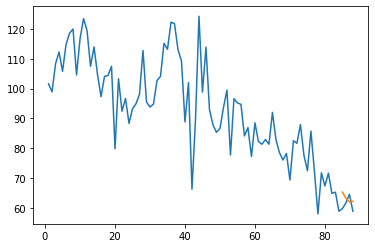

In [9]:
plt.plot(time, series)
plt.plot(time_valid, rnn_forecast)

Para que se vea mejor graficamos únicamente los valores que predijimos (en naranja) y los originales (en azul) y observamos que la diferencia entre ambas es bastante baja.

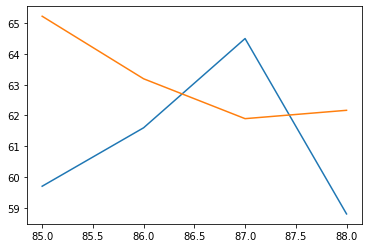

In [10]:
plt.plot(time_valid, x_valid)
plt.plot(time_valid, rnn_forecast)